# LAB 5. CONSTRAINED OPTIMIZATION: EQUALITY AND INEQUALITY CONSTRAINTS 

In this lab we are going to explore constrained optimization with equality and inequality constraints. This kind of problem appears, for example, when training Support Vector Machines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import QPGenericConstraints
import scipy.linalg as spla

In [2]:
help(QPGenericConstraints)

Help on function QPGenericConstraints in module QPGC:

QPGenericConstraints(G, g, A, C, b, d)
    Convex optimization problem with equality and inequality constraints:
     
               min f(x)=1/2 x^T G X + g^T x     s.t.   A^T x = b i C^T x >= d
    
    Call it with:
    
    x = QPGenericConstrains(G, g, A, C, b, d)
    
    Notation:
    
    n = number of variables
    p = number of equality constants
    m = number of inequality constants
     
    Dimensions:   G -> n x n
                  g -> n x 1
                  A -> n x p
                  C -> n x m
                  b -> p x 1  
                  d -> m x 1



In [3]:
def solve_system(G, A, C, x, g, b, d, gamma, lamb, s):
    r_L = np.dot(G, x) + g - np.dot(A, gamma) - np.dot(C, lamb)
    r_A = b - np.dot(A.T, x)
    r_C = s + d - np.dot(C.T, x)
    r_s = s * lamb

    rh_vector = np.hstack((r_L, r_A, r_C, r_s))

    return r_L, r_A, r_C, r_s, rh_vector


def Newton_step(lamb0, dlamb, s0, ds):
    alp = 1
    idx_lamb0 = np.array(np.where(dlamb < 0))

    if idx_lamb0.size > 0:
        alp = min(alp, np.min(-lamb0[idx_lamb0] / dlamb[idx_lamb0]))

    idx_s0 = np.array(np.where(ds < 0))

    if idx_s0.size > 0:
        alp = min(alp,np.min(-s0[idx_s0]/ds[idx_s0]))

    return alp


def solve_block_diagonal(D, y, tol=1e-16):
    n = D.shape[0]
    i = 0
    x = np.zeros_like(y)

    while i < n - 1:
        if max(abs(D[i, i+1]), abs(D[i+1, i])) < tol:
            x[i] = y[i] / D[i, i]
            i += 1
        else:
            x[i:i+2] = np.linalg.solve(D[i:i+2, i:i+2], y[i:i+2])
            i += 2

    x[i] = y[i] / D[i, i]

    return x


def ldl_block_solver(L, D, perm, rh_vector):
    n = L.shape[0]

    # Create inverse permutation array
    inv_perm = np.zeros_like(perm)
    for i in range(n):
        inv_perm[perm[i]] = i

    # Permute L matrix and array
    L = L[perm]
    rh_vector = rh_vector[perm]

    # Solve system
    x = spla.solve_triangular(L, rh_vector, lower=True)
    y = solve_block_diagonal(D, x)
    z = spla.solve_triangular(L.T, y)

    # Permute solution
    z = z[inv_perm]

    return z


def solver(G, A, C, g, b, d, lamb_0, gamma_0, s_0, x_0, max_iter=100, tol=1e-16, cond_num=False):
    # Copy initial values (these will be modified later on)
    x = np.copy(x_0)
    gamma = np.copy(gamma_0)
    lamb = np.copy(lamb_0)
    s = np.copy(s_0)

    # Get dimensions
    n, m = C.shape
    p = A.shape[1]
    N = n + p + m

    # Define values used in the algorithm
    e = np.ones(m)
    FACTOR = 0.95
    i = 0
    condition_numbers = []

    # Create M_kkt matrix
    M_kkt = np.zeros((N, N))

    M_kkt[:n, :n] = G
    M_kkt[:n, n:-m] = -A
    M_kkt[:n, -m:] = -C
    M_kkt[n:-m, :n] = -A.T
    M_kkt[-m:, :n] = -C.T

    # Compute initial values
    r_L, r_A, r_C, r_s, _ = solve_system(G, A, C, x, g, b, d, gamma, lamb, s)
    mu = np.dot(s, lamb) / m

    while np.linalg.norm(r_L) >= tol and np.linalg.norm(r_C) >= tol and np.linalg.norm(mu) >= tol and i < max_iter:
        i += 1

        # Compute variable part of M_kkt matrix
        M_kkt[-m:, -m:] = -np.diagflat(s / lamb)

        # Compute LDL^T factorization
        L_kkt, D_kkt, perm = spla.ldl(M_kkt)

        # Compute condition number
        if cond_num:
            condition_numbers.append(np.linalg.cond(M_kkt, np.inf))

        # Step 1: Solve system
        rh_vector = np.hstack((r_L, r_A, r_C - r_s / lamb))

        d_z = ldl_block_solver(L_kkt, D_kkt, perm, -rh_vector)
        d_x, d_gamma, d_lamb = d_z[:n], d_z[n:-m], d_z[-m:]
        d_s = -(r_s + s * d_lamb) / lamb

        # Step 2: Step-size correction substep
        alpha = Newton_step(lamb, d_lamb, s, d_s)

        # Step 3: Compute correctors
        mu_tilda = np.dot(s + alpha * d_s, lamb + alpha * d_lamb) / m
        sigma = (mu_tilda / mu) ** 3

        # Step 4: Corrector substep
        # The matrix multiplication D_s D_{\lambda} e can be substituted by the
        # element-wise multiplication of d_s and d_{\lambda}
        r_s = r_s + d_s * d_lamb - sigma * mu * e
        rh_vector = np.hstack((r_L, r_A, r_C - r_s / lamb))

        d_z = ldl_block_solver(L_kkt, D_kkt, perm, -rh_vector)
        d_x, d_gamma, d_lamb = d_z[:n], d_z[n:-m], d_z[-m:]
        d_s = -(r_s + s * d_lamb) / lamb

        # Step 5: Step-size correction substep
        alpha = Newton_step(lamb, d_lamb, s, d_s)

        # Step 6: Update values
        x += FACTOR * alpha * d_x
        gamma += FACTOR * alpha * d_gamma
        lamb += FACTOR * alpha * d_lamb
        s += FACTOR * alpha * d_s

        r_L, r_A, r_C, r_s, _ = solve_system(G, A, C, x, g, b, d, gamma, lamb, s)

        mu = np.dot(s, lamb) / m


    return x, i, condition_numbers

In [4]:
def generate_sample(m1, s1, m2, s2, n_samples, row_format=False):  # n_samples = m
    n_samples_class = n_samples // 2
    
    X_positive = np.random.multivariate_normal(m1, s1, n_samples_class)
    X_negative = np.random.multivariate_normal(m2, s2, n_samples_class)
    
    X = np.vstack([X_positive, X_negative])
    
    if row_format:
        X = X.T
    
    y = np.r_[np.ones(n_samples_class), -np.ones(n_samples_class)]
    
    return X, y

In [5]:
def plot_sample(X, y, row_format=False):
    cdict = {1: 'green', -1: 'red'}
    
    if row_format:
        X = X.T
    
    for c in np.unique(y):
        idx = np.where(y == c)
        plt.scatter(X[idx, 0], X[idx, 1], c=cdict[c], s=10, alpha=0.75, label=int(c))
    
    plt.legend()
    plt.show()


def plot_svm(X, y, w, b, row_format=False):
    cdict = {1: 'green', -1: 'red'}
    
    if row_format:
        X = X.T
    
    p_x1 = np.arange(np.min(X[:, 0]) - 1, np.max(X[:, 0]) + 1, 0.1)
    p_x2 = np.arange(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1, 0.1)
    p_x1, p_x2 = np.meshgrid(p_x1, p_x2)
    p_y = w[0] * p_x1 + w[1] * p_x2 + b

    fig, ax = plt.subplots()
    cp = ax.contour(p_x1,p_x2,p_y,[-1,0,1])
    
    for c in np.unique(y):
        idx = np.where(y == c)
        ax.scatter(X[idx, 0], X[idx, 1], c=cdict[c], s=10, alpha=0.75, label=int(c))
    
    plt.legend()
    plt.show()

In [6]:
def create_dual_formulation(X, y, n_samples, K=1):
    n = n_samples
    p, m = 1, 2*n

    Y = np.diagflat(y)
    identity_mat = np.eye(n)
    ones = np.ones(n)
    
    G = np.dot(Y, np.dot(X.T, np.dot(X, Y)))
    g = -ones
    A = y.reshape(-1, 1)
    C = np.hstack([identity_mat, -identity_mat])
    b = np.zeros(1)
    d = np.r_[np.zeros(n), -K * ones]
    
    # Set values for initial point
    alpha_0, s_0, gamma_0, lamb_0 = np.zeros(n), np.ones(m), np.ones(p), np.ones(m)
    
    return G, g, A, C, b, d, alpha_0, s_0, gamma_0, lamb_0


def svm_dual_space(X, y, n_samples, K=1, plot_results=True):
    # Create the data for the formulation in the dual space
    G, g, A, C, b, d, alpha_0, s_0, gamma_0, lamb_0 = create_dual_formulation(X, y, n_samples, K=K)
    
    # Solve the problem and get the \alpha values
    alpha, i, _ = solver(G, A, C, g, b, d, lamb_0, gamma_0, s_0, alpha_0)
    
    # Get the hyperplane and the bias
    w = np.dot(alpha * y, X.T)
    
    idx = np.where(alpha > 1e-6)[0]
    b = np.mean(y[idx] - np.dot(w, X[:, idx]))
    
    if plot_results:
        plot_svm(X, y, w, b, row_format=True)
    
    return w, b

In [7]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

## Simple case

First, we are going to test how solving the problem in the dual space works with a very simple case in which we have two separable classes with two samples each one. We want to see if we can get a hyperplane that separates the points of both classes and has maximal marigin. So, let's generate the data and solve the problem via the dual formulation.

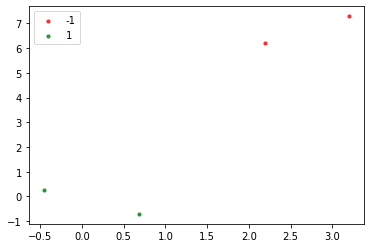

In [8]:
n_samples = 4
K = 1

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

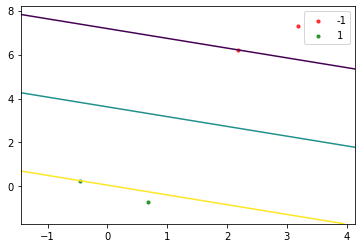

w: [-0.12460295 -0.2805886 ]	b: 1.0156282638135257


In [9]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

As we can see, we have obtained a hyperplane with maximal margin. There are three points that have been considered **support vectors**: the two points from the class $1$ and the one closest to the margin of the class $1$. Therefore, the classification lines at levels $-1$ and $+1$ go through them. There ara no points that fall inside the margin. Thus, we can see that this method is perfectly capable of solving this problem.

## A separable case with more data

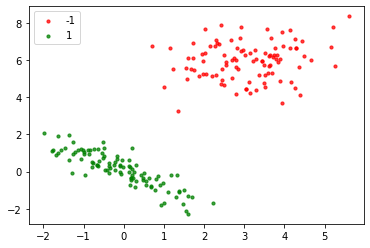

In [10]:
n_samples = 200
X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

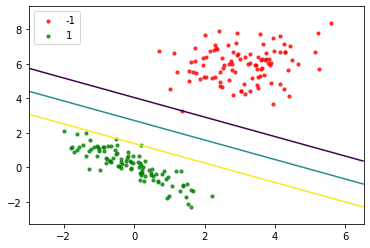

w: [-0.42589852 -0.75199193]	b: 2.038966223931168


In [11]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

## Experimenting with different values of $K$

Let us now test different values of $K$ and see how this affects the result. We are going to repeat each experiment 3 times to see if the results are consistent for the same value of $K$.

In [17]:
def test_k_values(X, y, n_samples, K_list):
    for K in K_list:
        print(f'\n\n---------- Results for K={K} ----------\n\n')
        for _ in range(3):
            try:
                w, b = svm_dual_space(X, y, n_samples, K=K)
                print(f'w: {w}\tb: {b}')
            except ValueError as e:
                print('Error: ', e)



---------- Results for K=1 ----------




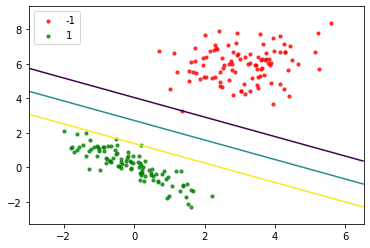

w: [-0.42589852 -0.75199193]	b: 2.038966223931168


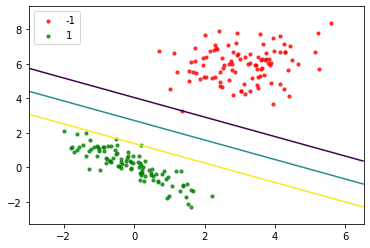

w: [-0.42589852 -0.75199193]	b: 2.038966223931168


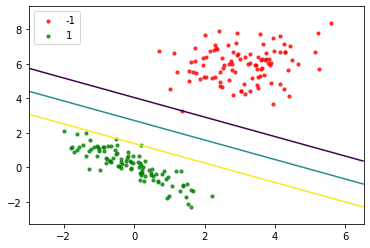

w: [-0.42589852 -0.75199193]	b: 2.038966223931168


---------- Results for K=10 ----------




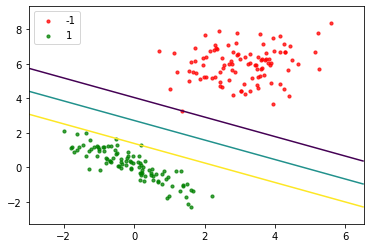

w: [-0.42589852 -0.75199193]	b: 2.0389662239311686


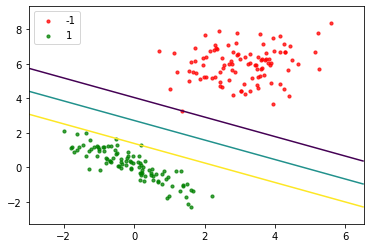

w: [-0.42589852 -0.75199193]	b: 2.0389662239311686


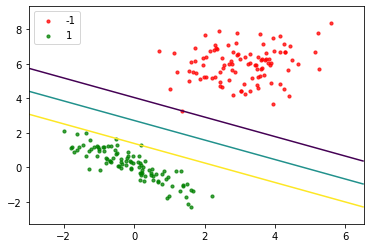

w: [-0.42589852 -0.75199193]	b: 2.0389662239311686


---------- Results for K=100 ----------




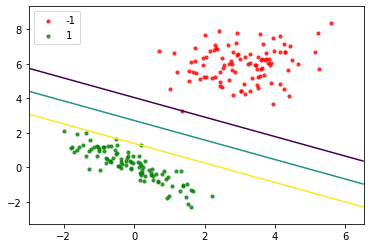

w: [-0.42589852 -0.75199193]	b: 2.03896622393117


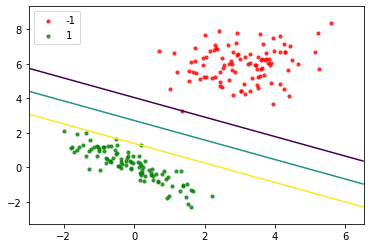

w: [-0.42589852 -0.75199193]	b: 2.03896622393117


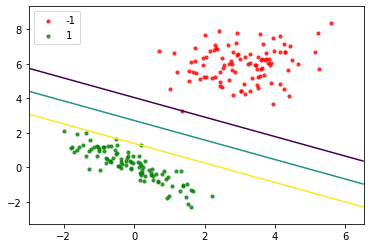

w: [-0.42589852 -0.75199193]	b: 2.03896622393117


---------- Results for K=1000 ----------




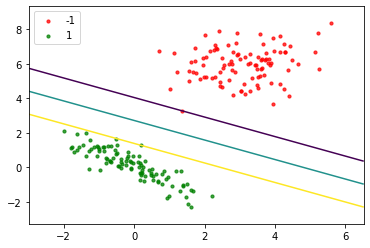

w: [-0.42589852 -0.75199193]	b: 2.0389662239311726


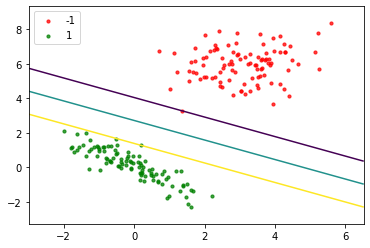

w: [-0.42589852 -0.75199193]	b: 2.0389662239311726


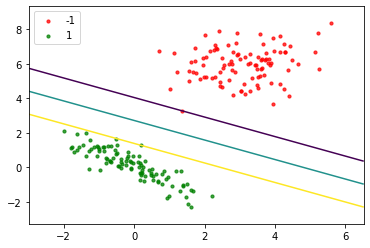

w: [-0.42589852 -0.75199193]	b: 2.0389662239311726


---------- Results for K=1000000.0 ----------




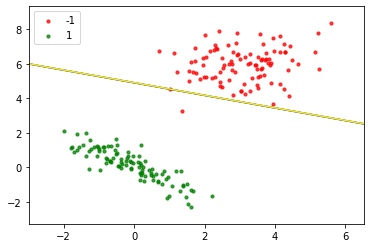

w: [ 90.45550745 247.36152837]	b: -1212.0538443214948


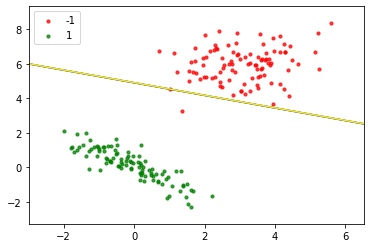

w: [ 90.45550745 247.36152837]	b: -1212.0538443214948


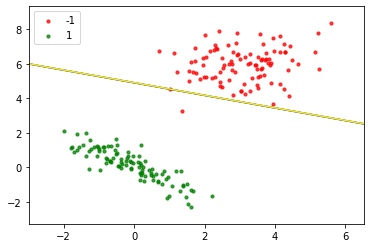

w: [ 90.45550745 247.36152837]	b: -1212.0538443214948


---------- Results for K=100000000.0 ----------




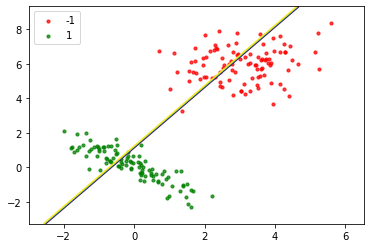

w: [-34.56834095  19.73815748]	b: -23.089120969974896


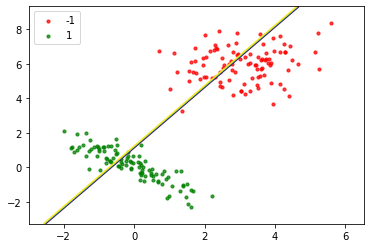

w: [-34.56834095  19.73815748]	b: -23.089120969974896


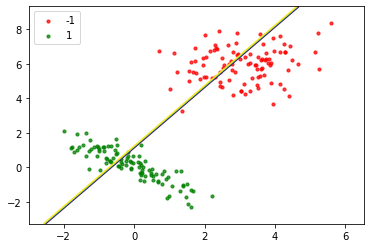

w: [-34.56834095  19.73815748]	b: -23.089120969974896


---------- Results for K=10000000000.0 ----------




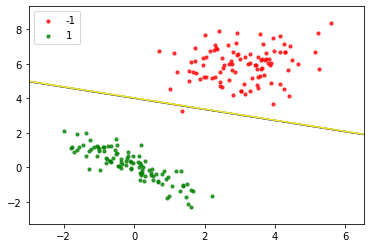

w: [ 35.49095638 109.89609372]	b: -440.52755268237956


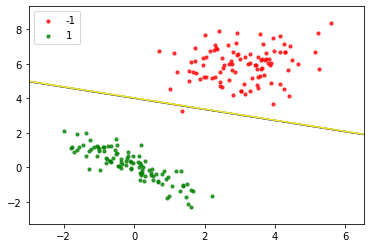

w: [ 35.49095638 109.89609372]	b: -440.52755268237956


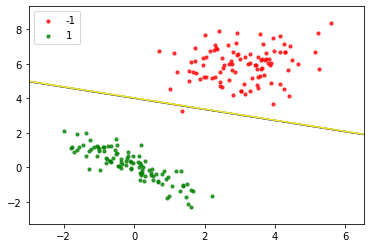

w: [ 35.49095638 109.89609372]	b: -440.52755268237956


---------- Results for K=1000000000000.0 ----------




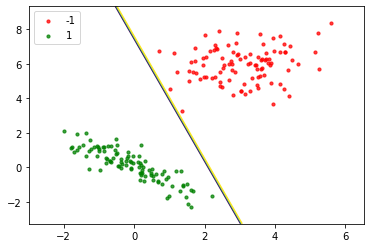

w: [46.51623824 13.12109526]	b: -98.74136618286751


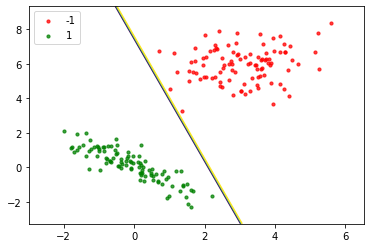

w: [46.51623824 13.12109526]	b: -98.74136618286751


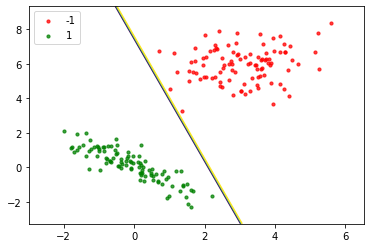

w: [46.51623824 13.12109526]	b: -98.74136618286751


In [13]:
K_list = [1, 10, 100, 1000, 1e6, 1e8, 1e10, 1e12]

test_k_values(X, y, n_samples, K_list)

Comment on the results here. There might be some problem with $K$.

## Non-separable case

After seeing how this method to obtain the SVM works with separable data, let's address a more real case scenario in which the data is non-separable.

First, we are going to generate the data and make a quick test on this method performs.

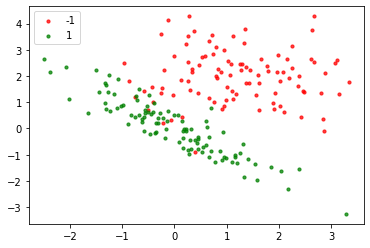

In [14]:
# Generate non-separable dataset
n_samples = 200
X, y = generate_sample(m1, s1, m2nsep, s2nsep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

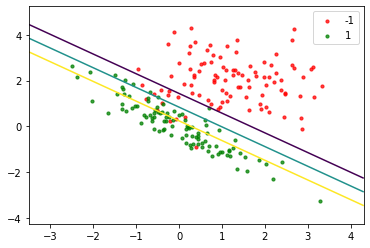

w: [-1.43852708 -1.67061787]	b: 1.4007117709732197


In [15]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

Here we shall comment the obtained results.



---------- Results for K=1 ----------




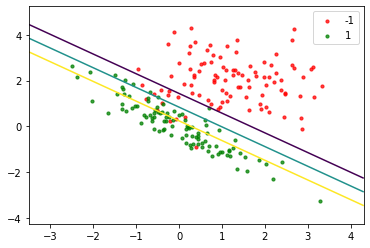

w: [-1.43852708 -1.67061787]	b: 1.4007117709732197


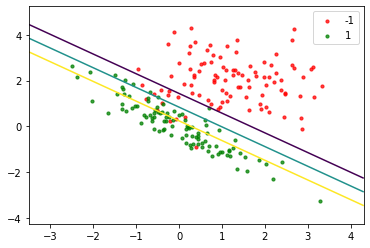

w: [-1.43852708 -1.67061787]	b: 1.4007117709732197


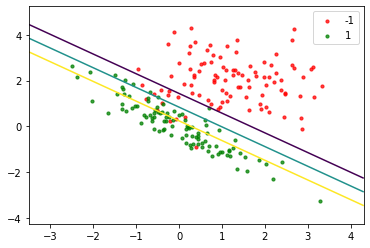

w: [-1.43852708 -1.67061787]	b: 1.4007117709732197


---------- Results for K=10 ----------




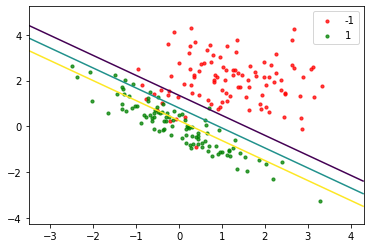

w: [-1.58653754 -1.81752363]	b: 1.457799618782567


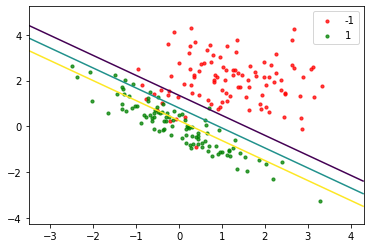

w: [-1.58653754 -1.81752363]	b: 1.457799618782567


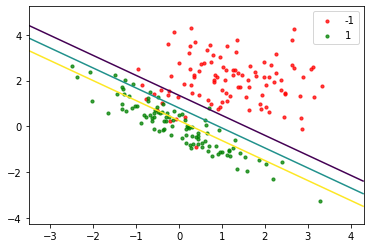

w: [-1.58653754 -1.81752363]	b: 1.457799618782567


---------- Results for K=100 ----------




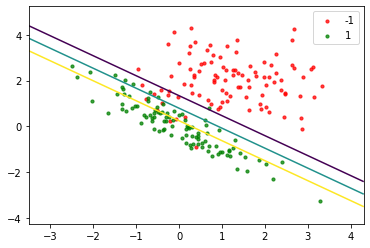

w: [-1.5962558  -1.82865678]	b: 1.4489083154127729


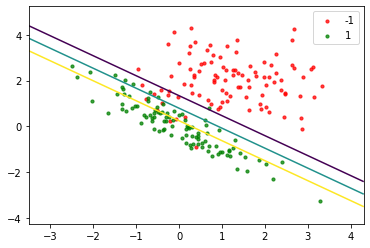

w: [-1.5962558  -1.82865678]	b: 1.4489083154127729


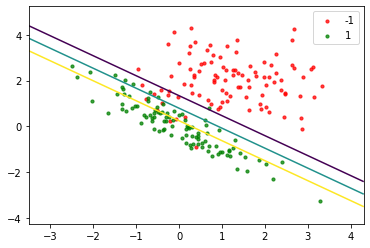

w: [-1.5962558  -1.82865678]	b: 1.4489083154127729


---------- Results for K=1000 ----------




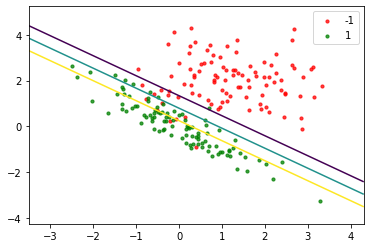

w: [-1.60256077 -1.83331325]	b: 1.452092437674805


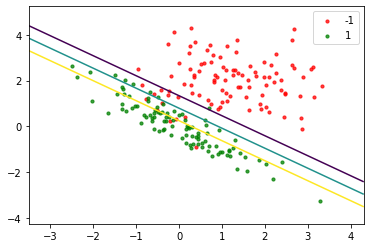

w: [-1.60256077 -1.83331325]	b: 1.452092437674805


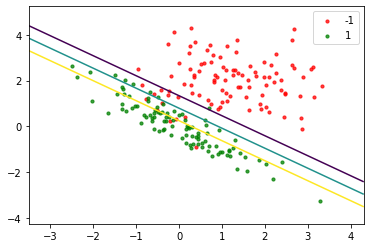

w: [-1.60256077 -1.83331325]	b: 1.452092437674805


---------- Results for K=1000000.0 ----------




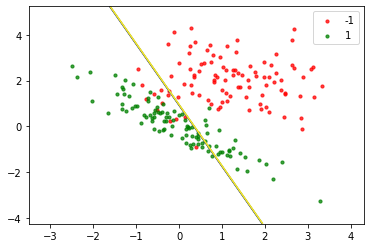

w: [196.96149031  73.74098017]	b: -69.36858705056386


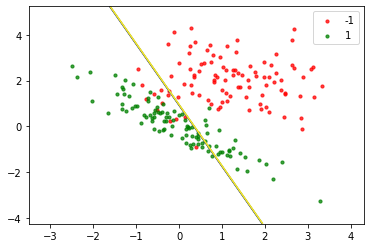

w: [196.96149031  73.74098017]	b: -69.36858705056386


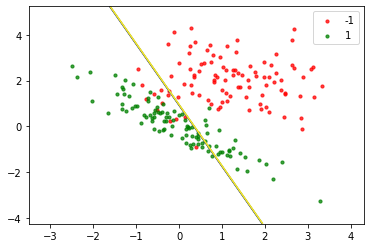

w: [196.96149031  73.74098017]	b: -69.36858705056386


---------- Results for K=100000000.0 ----------




/tmp/ipykernel_97863/2935113381.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  x[i] = y[i] / D[i, i]


Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs


---------- Results for K=10000000000.0 ----------


Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs


---------- Results for K=1000000000000.0 ----------




/tmp/ipykernel_97863/2935113381.py:34: RuntimeWarning: overflow encountered in double_scalars
  x[i] = y[i] / D[i, i]


Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs
Error:  array must not contain infs or NaNs


In [18]:
K_list = [1, 10, 100, 1000, 1e6, 1e8, 1e10, 1e12]

test_k_values(X, y, n_samples, K_list)

# LAB 6: STOCHASTIC GRADIENT DESCENT FOR SVM

In [19]:
def f(X, y, lamb, w, b):
    return 0.5 * lamb * np.dot(w, w) + np.sum(np.maximum(0, 1 - y * (np.dot(X, w) + b)))


def stochastic_gradient_descent(X, y, n_epochs=500, mu_0=100, mu_increment=0.1, lamb=1e-4, batch_size=10, plot_result=True):
    n_samples = X.shape[0]
    mu = mu_0
    
    # Declare parameters
    w = np.array([1., 1.])
    b = 0
    
    log_f_values = [np.log(f(X, y, lamb, w, b))]
    
    for j in range(n_epochs):
        shuffle_idx = np.random.permutation(np.arange(n_samples))
        X_shuffled, y_shuffled = X[shuffle_idx], y[shuffle_idx]
                
        for i in range(0, n_samples, batch_size):
            gamma = 1 / mu

            X_mini_batch, y_mini_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]
            
            mask = y_mini_batch * (np.dot(X_mini_batch, w) + b) <= 1
            
            # y needs to be transformed so that the element wise multiplication
            # with the elements of the batch can be performed            
            w = w - gamma * (lamb * w + np.sum(-y_mini_batch[mask, np.newaxis] * X_mini_batch[mask], axis=0))
            b = b - gamma * np.sum(-y_mini_batch[mask])
            
            mu += mu_increment
        
        log_f_values.append(np.log(f(X, y, lamb, w, b)))
    
    if plot_result:
        plot_svm(X, y, w, b)
    
    return w, b, np.array(log_f_values)

In [20]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

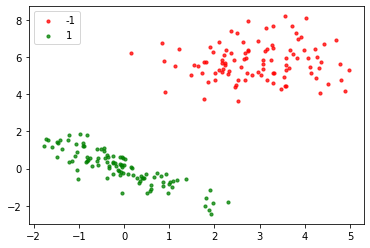

In [21]:
n_samples = 200

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples)
plot_sample(X, y)

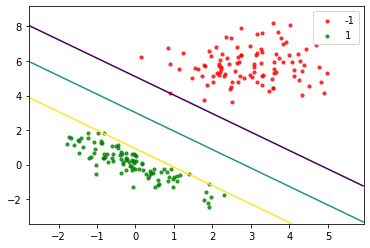

In [22]:
w, b, log_f_values_1 = stochastic_gradient_descent(X, y, batch_size=1, n_epochs=2000)

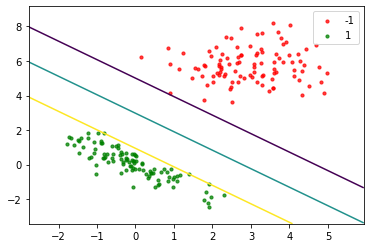

In [23]:
w, b, log_f_values_20 = stochastic_gradient_descent(X, y, batch_size=20, n_epochs=2000)

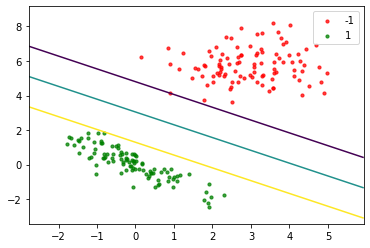

In [24]:
w, b, log_f_values_200 = stochastic_gradient_descent(X, y, batch_size=200, n_epochs=2000, lamb=1, mu_increment=0.01)

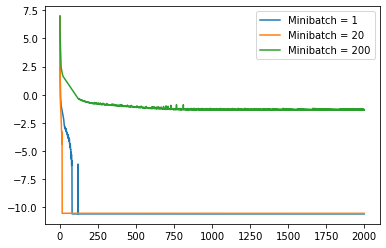

In [25]:
plt.plot(np.arange(len(log_f_values_1)), log_f_values_1, label='Minibatch = 1')
plt.plot(np.arange(len(log_f_values_20)), log_f_values_20, label='Minibatch = 20')
plt.plot(np.arange(len(log_f_values_200)), log_f_values_200, label='Minibatch = 200')

plt.legend()
plt.show()

## Non-separable case

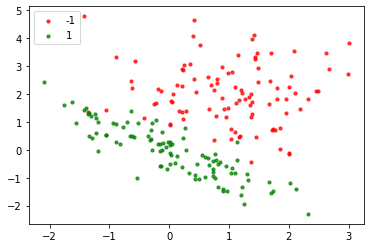

In [26]:
n_samples = 200

X, y = generate_sample(m1, s1, m2nsep, s2nsep, n_samples)
plot_sample(X, y)

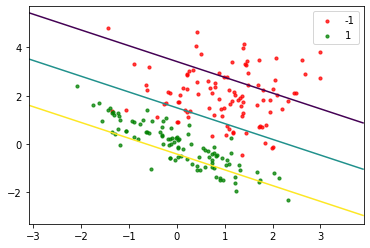

In [27]:
w, b, log_f_values_1 = stochastic_gradient_descent(X, y, batch_size=1, n_epochs=2000, lamb=1, mu_increment=0.01)

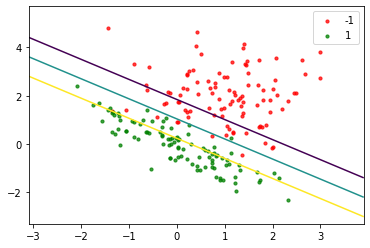

In [28]:
w, b, log_f_values_20 = stochastic_gradient_descent(X, y, batch_size=20, n_epochs=2000, lamb=1, mu_increment=0.01)

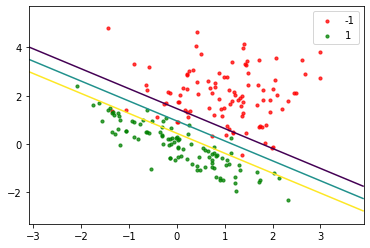

In [29]:
w, b, log_f_values_200 = stochastic_gradient_descent(X, y, batch_size=200, n_epochs=2000, lamb=1, mu_increment=0.01)

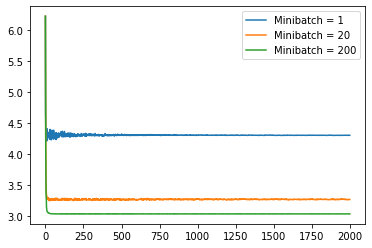

In [30]:
plt.plot(np.arange(len(log_f_values_1)), log_f_values_1, label='Minibatch = 1')
plt.plot(np.arange(len(log_f_values_20)), log_f_values_20, label='Minibatch = 20')
plt.plot(np.arange(len(log_f_values_200)), log_f_values_200, label='Minibatch = 200')

plt.legend()
plt.show()